In [41]:
import contextily as ctx
import folium
import geopandas as gpd
import pandas as pd
import requests


In [ ]:
output_maps_path = '/home/marthe/Documents/DS/Basta/cartes/'

In [43]:
# Importation des données géographiques des quartiers de Marseille
url = 'https://www.data.gouv.fr/api/1/datasets/r/8a8f7f54-7f91-482c-a78c-dd09d893d1b6'
file = requests.get(url)
data = file.content
marseille_quartiers_data = gpd.read_file(data)

In [44]:
marseille_quartiers_data.info()
marseille_quartiers_data.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   DEPCO     111 non-null    str     
 1   NOM_CO    111 non-null    str     
 2   NOM_QUA   111 non-null    str     
 3   geometry  111 non-null    geometry
dtypes: geometry(1), str(3)
memory usage: 3.6 KB


,DEPCO,NOM_CO,NOM_QUA,geometry
0,13201,Marseille 1er Arrondissemen,BELSUNCE,"MULTIPOLYGON (((5.38086 43.29924, 5.38087 43.2..."
1,13201,Marseille 1er Arrondissemen,CHAPITRE,"MULTIPOLYGON (((5.38525 43.29906, 5.38485 43.2..."
2,13201,Marseille 1er Arrondissemen,NOAILLES,"MULTIPOLYGON (((5.3816 43.29573, 5.38177 43.29..."
3,13201,Marseille 1er Arrondissemen,OPERA,"MULTIPOLYGON (((5.37729 43.29222, 5.37663 43.2..."
4,13201,Marseille 1er Arrondissemen,SAINT CHARLES,"MULTIPOLYGON (((5.38022 43.30141, 5.38007 43.3..."


In [45]:
marseille_quartiers_map = marseille_quartiers_data.rename({'NOM_QUA' : 'Quartier'}, axis = 1)
marseille_quartiers_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
# Importation des données concernant les points d'apport volontaire
url = 'https://www.data.gouv.fr/api/1/datasets/r/e46c6879-49e7-4727-8f3b-62df90ac5a5a'
gouv_data = pd.read_csv(url, sep = ';')
gouv_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 12773 entries, 0 to 12772
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   OBJECTID                          12773 non-null  int64  
 1   Ex identifiant CT                 12066 non-null  str    
 2   Date création mobilier            12693 non-null  str    
 3   Famille Osis                      12773 non-null  str    
 4   Type de colonne                   12749 non-null  str    
 5   Modèle                            11436 non-null  str    
 6   Volume intérieur m3               8532 non-null   float64
 7   longitude                         12773 non-null  float64
 8   latitude                          12773 non-null  float64
 9   Date de mise à jour de la donnée  12773 non-null  str    
 10  Code Commune INSEE                12763 non-null  float64
 11  Commune                           12763 non-null  str    
 12  Position       

In [47]:
# Extraction des variables d'intérêt
bacs_data = gouv_data[['OBJECTID', 'Code Commune INSEE', 'Quartier', 'Volume intérieur m3', 'longitude', 'latitude']]


In [48]:
# Extraction des observations concernant les quartiers de Marseille
bacs_marseille = bacs_data.loc[(bacs_data['Code Commune INSEE'] > 13200) & (bacs_data['Code Commune INSEE'] < 13217)]
bacs_marseille_quartiers = bacs_marseille.dropna(axis = 0, subset = ['Quartier'])
bacs_marseille_quartiers.head()

# conversion en geodataframe
bacs_marseille_quartiers = gpd.GeoDataFrame(
    bacs_marseille_quartiers,
    geometry=gpd.points_from_xy(
        bacs_marseille_quartiers['longitude'],
        bacs_marseille_quartiers['latitude'],
        crs="EPSG:4326"))

bacs_marseille_quartiers = bacs_marseille_quartiers.to_crs(3857)

In [49]:
# Uniformisation des noms de quartiers 

marseille_quartiers_map['Quartier'] = marseille_quartiers_map['Quartier'].replace(
    {
        'SAINT MAURON' : 'SAINT MAURONT',
        'VIELLE CHAPELLE' : 'VIEILLE CHAPELLE'
    }
)

bacs_marseille_quartiers['Quartier'] = bacs_marseille_quartiers['Quartier'].replace(
    {
    'CHATEAU GOMBERT' : 'CHATEAU-GOMBERT',
    'LA POINTE ROUGE' : 'POINTE ROUGE',
    'LA VILLETTE' : 'LA VILETTE',
    'LE ROUCAS' : 'ROUCAS BLANC',
    'LE ROUCAS BLANC' : 'ROUCAS BLANC',
    'LES CHUTES LAVIES' : 'CHUTES LAVIE',
    'LES CINQ AVENUES' : 'CINQ AVENUES',
    'LES GRANDS CARMES' : 'GRANDS CARMES',
    'ST BARNANE' : 'SAINT BARNABE',
    'STE MARGUERITE' : 'SAINTE MARGUERITE'
}
)


In [50]:
# Trop de données manquantes sur le volume de points d'apport à l'échelle du quartier...
print(bacs_marseille_quartiers.isna().mean())

# On se contente de récupérer le nombre de points d'apport par quartier
nb_bacs_quartier = bacs_marseille_quartiers.groupby('Quartier').count()['OBJECTID']

OBJECTID               0.000000
Code Commune INSEE     0.000000
Quartier               0.000000
Volume intérieur m3    0.436031
longitude              0.000000
latitude               0.000000
geometry               0.000000
dtype: float64


In [51]:
# merge des données de carte, de population et de volume des points d'apport
marseille = marseille_quartiers_map.merge(nb_bacs_quartier, on = 'Quartier').rename({'OBJECTID' : 'nb_points'}, axis = 1)

In [52]:
marseille

,DEPCO,NOM_CO,Quartier,geometry,nb_points
0,13201,Marseille 1er Arrondissemen,BELSUNCE,"MULTIPOLYGON (((5.38086 43.29924, 5.38087 43.2...",69
1,13201,Marseille 1er Arrondissemen,CHAPITRE,"MULTIPOLYGON (((5.38525 43.29906, 5.38485 43.2...",58
2,13201,Marseille 1er Arrondissemen,NOAILLES,"MULTIPOLYGON (((5.3816 43.29573, 5.38177 43.29...",14
3,13201,Marseille 1er Arrondissemen,OPERA,"MULTIPOLYGON (((5.37729 43.29222, 5.37663 43.2...",59
4,13201,Marseille 1er Arrondissemen,SAINT CHARLES,"MULTIPOLYGON (((5.38022 43.30141, 5.38007 43.3...",74
...,...,...,...,...,...
104,13215,Marseille 15e Arrondissemen,LA VISTE,"MULTIPOLYGON (((5.35771 43.35337, 5.35756 43.3...",109
105,13216,Marseille 16e Arrondissemen,L'ESTAQUE,"MULTIPOLYGON (((5.32691 43.36112, 5.32694 43.3...",57
106,13216,Marseille 16e Arrondissemen,LES RIAUX,"MULTIPOLYGON (((5.30862 43.36508, 5.30878 43.3...",5
107,13216,Marseille 16e Arrondissemen,SAINT ANDRE,"MULTIPOLYGON (((5.33997 43.34367, 5.33992 43.3...",25


In [53]:
marseille = marseille.to_crs(3857)

In [54]:
# Calcul de la densité des points d'apport par quartier
marseille['area'] = marseille['geometry'].area
marseille['densité_bacs'] = marseille['nb_points']/marseille['area']

In [55]:
bacs_marseille_quartiers.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

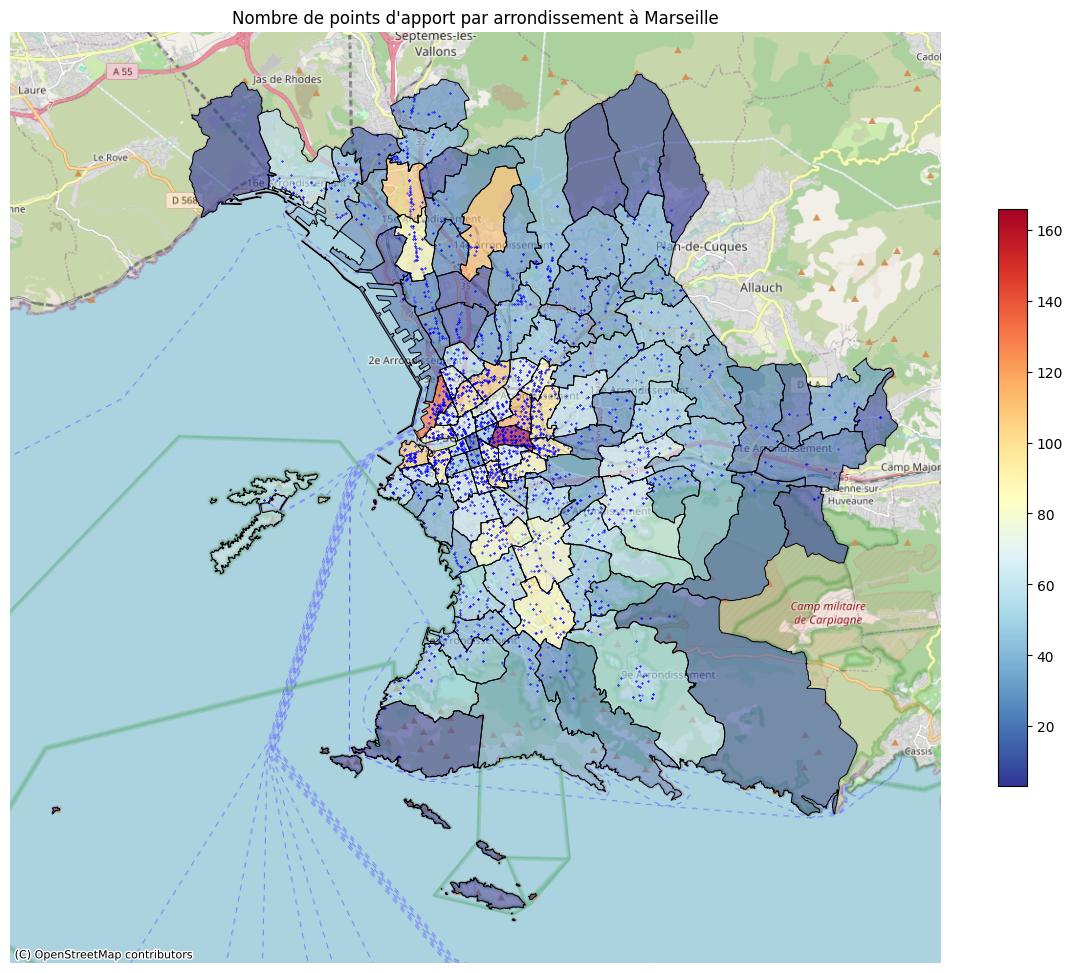

In [56]:
base = marseille.boundary.plot(edgecolor = 'black', linewidth = 0.7, figsize = (15,15))

marseille.plot(
    ax = base,
    column = 'nb_points',
    cmap = 'RdYlBu_r',
    alpha = 0.6,
    legend = True,
    legend_kwds={'shrink': 0.5})

bacs_marseille_quartiers.plot(
    ax = base,
    color = 'Blue',
    markersize = 0.1

)

ctx.add_basemap(ax = base, source = ctx.providers.OpenStreetMap.Mapnik)

base.set_axis_off()

base.set_title("Nombre de points d'apport par arrondissement à Marseille");


In [62]:
map = folium.Map(
    location = [43.3, 5.4],
    tiles = 'OpenStreetMap',
    zoom_start = 12,
    max_zoom=23,
    control_scale=True)

bacs_marseille_quartiers.explore(
    m = map,
    marker_kwds=dict(radius=1, fill=True),
    color = 'Grey'
)

marseille.explore(
    m = map, 
    column = 'nb_points',
    tooltip = ['Quartier', 'nb_points'],
    popup = True,
    cmap = 'RdYlBu_r',
    legend = False)


map_title = "Nombre de points d'apports par quartier"
title_html = f'<h1 style="position:absolute;z-index:100000;left:40vw" >{map_title}</h1>'
map.get_root().html.add_child(folium.Element(title_html))


map.save(output_maps_path + 'map_nb_bacs_quartier.html')




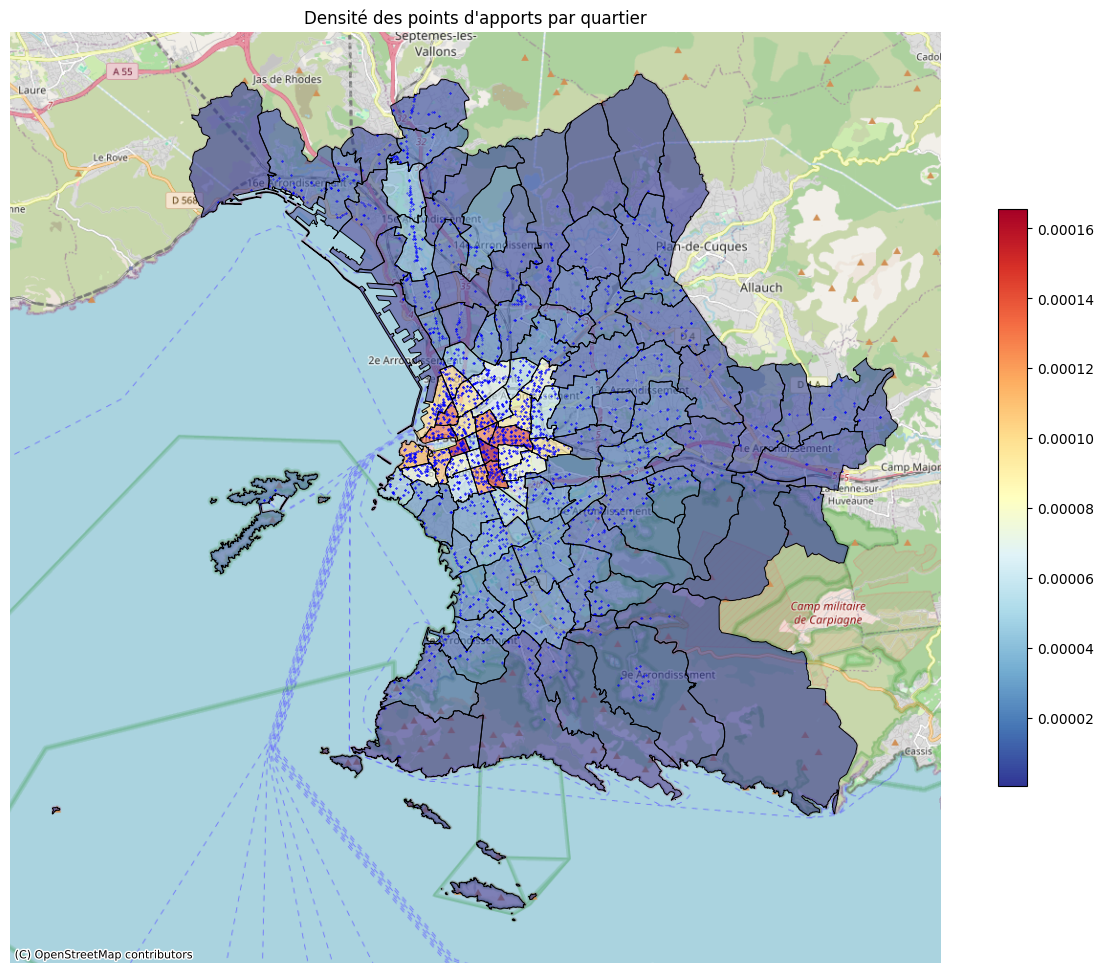

In [58]:
base = marseille.boundary.plot(edgecolor = 'black', linewidth = 0.7, figsize = (15,15))

marseille.plot(
    ax = base,
    column = 'densité_bacs',
    cmap = 'RdYlBu_r',
    alpha = 0.6,
    legend = True,
    legend_kwds={'shrink': 0.5})


bacs_marseille_quartiers.plot(
    ax = base,
    color = 'Blue',
    markersize = 0.1

)

ctx.add_basemap(ax = base, source = ctx.providers.OpenStreetMap.Mapnik)

base.set_axis_off()

base.set_title("Densité des points d'apports par quartier");


In [63]:
map = folium.Map(
    location = [43.3, 5.4],
    tiles = 'OpenStreetMap',
    zoom_start = 12,
    max_zoom=23,
    control_scale=True)

bacs_marseille_quartiers.explore(
    m = map,
    marker_kwds=dict(radius=1, fill=True),
    color = 'Grey'
)

marseille.explore(
    m = map, 
    column = 'densité_bacs',
    tooltip = ['Quartier', 'nb_points'],
    popup = True,
    cmap = 'RdYlBu_r',
    legend = False)

map_title = "Densité des points d'apports par quartier"
title_html = f'<h1 style="position:absolute;z-index:100000;left:40vw" >{map_title}</h1>'
map.get_root().html.add_child(folium.Element(title_html))


map.save(output_maps_path + 'map_densité_bacs_quartier.html')
